In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Chargement des données

On télécharge les données d'une série artificielle : [l'attracteur de Lorenz](https://fr.wikipedia.org/wiki/Attracteur_de_Lorenz). C'est une structure cahotique non linéaire et nous allons utiliser ces propriétés afin de mettre en évidence que le modèle créé permet effectivement de gérer ce genre de séries temporelles.

In [3]:
# Récupération des données au format .csv
!rm *.csv
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv"

rm: cannot remove '*.csv': No such file or directory
--2023-09-06 09:59:19--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34567 (34K) [text/plain]
Saving to: ‘LorenzMap.csv’

LorenzMap.csv       100%[===================>]  33.76K  --.-KB/s    in 0.002s  

2023-09-06 09:59:19 (14.2 MB/s) - ‘LorenzMap.csv’ saved [34567/34567]



Charge la série sous Pandas et affiche les informations du fichier :

In [4]:
# Création de la série sous Pandas
serie = pd.read_csv("LorenzMap.csv", names=['X','Y','Z'])
serie

,X,Y,Z
0,0.000000,1.00000,1.0500
1,0.048931,0.99832,1.0362
2,0.095542,1.00310,1.0227
3,0.140250,1.01400,1.0097
4,0.183460,1.03090,0.9971
...,...,...,...
1552,1.282300,-1.93910,25.2700
1553,0.901650,-1.87140,24.4010
1554,0.574140,-1.81070,23.5710
1555,0.292540,-1.76190,22.7750


In [5]:
serie = serie.astype(dtype='float32')
serie.dtypes

X    float32
Y    float32
Z    float32
dtype: object

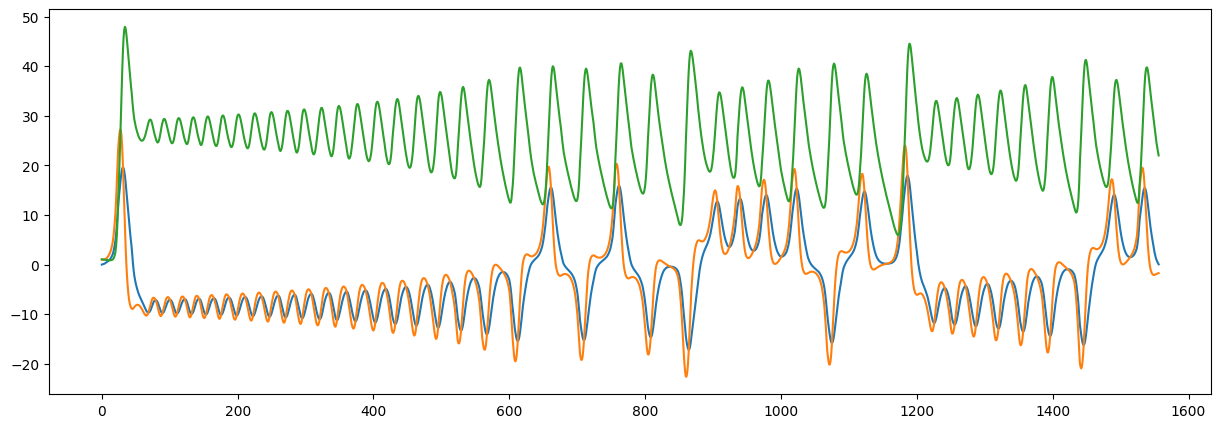

In [6]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(serie.index, serie['X'],serie['Y'])
plt.plot(serie.index, serie['Z'])


# Séparation des données de test et d'entrainement

In [7]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(serie.values) * pourcentage)
date_separation = serie.index[temps_separation]

serie_entrainement_X = np.array(serie.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(serie.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 1245
Taille de la validation : 312


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [8]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(serie.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

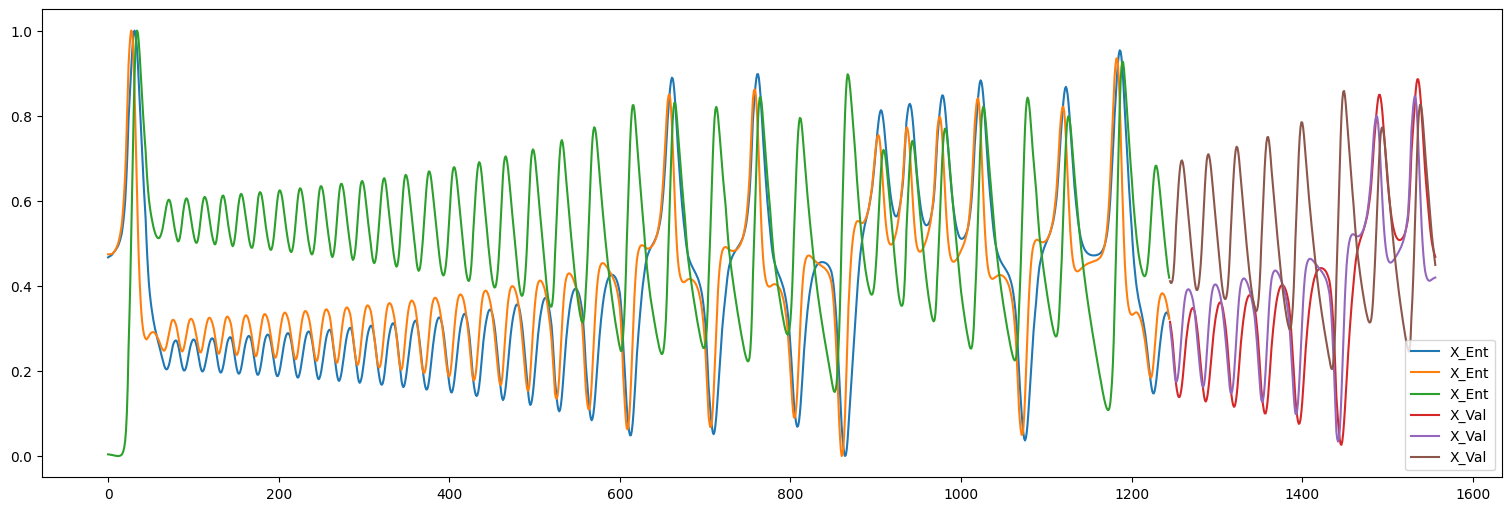

In [9]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(serie.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(serie.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création du modèle type Wavenet Univarié

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Wavenet/images/Wavenet_finance.png?raw=true">

**1. Création du réseau**

In [10]:
import keras.backend as K

# longueur_sequence :   Longueur de la séquence d'entrée (dépend de la profondeur de dilation)
# nbr_filtres :         Nombres de filtres CNN dans les couches
# dim_filtres :         Dimension des filtres CNN
# profondeur_dilation : Profondeur de dilation
# use_bias :            Utilisation ou non de l'offset
# res_l2 :              Régularisation l2 des couches CNN
# final_l2 :            Régularisation l2 de la couche de sortie

def get_model(longueur_sequence, nbr_filtres, dim_filtres, prodondeur_dilation, use_bias, res_l2, final_l2):
  input_shape = tf.keras.Input(shape=(longueur_sequence, 1), name='input_part')

  # Convolution causale d'entrée
  out = K.temporal_padding(input_shape, padding=((dim_filtres-1), 0))
  out = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=1,use_bias=True,activation=None,
                            name='convolution_causale',kernel_regularizer=tf.keras.regularizers.l2(res_l2))(out)

  # Convolutions dilatées intermédiaires
  res_x = out
  skip = []
  for i in range(1, prodondeur_dilation + 1):
    z = K.temporal_padding(res_x, padding=(2**i * (dim_filtres - 1), 0))
    z = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=2**i,use_bias=True,activation="relu",
                            name='convolution_causale_%i' %i, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)

    skip_x = tf.keras.layers.Conv1D(1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)
    res_x = tf.keras.layers.Conv1D(1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)

    res_x = tf.keras.layers.Add()([out, res_x])
    out = res_x
    skip.append(skip_x)

  # Addition des sorties intermédiaires
  out = tf.keras.layers.Add()(skip)

  # Couche de sortie
  out = tf.keras.layers.Activation('linear', name="output_linear")(out)
  out = tf.keras.layers.Conv1D(1, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(final_l2))(out)
  model = tf.keras.Model(input_shape, out[:,-1:,:])
  return model


**2. Construction du modèle**

In [11]:
def calcul_longueur_sequence(prodondeur_dilation):
  return (2 ** prodondeur_dilation * 2)

In [12]:
nbr_filtres = 2
dim_filtres = 2
profondeur_dilation = 3         # longueur_sequence = 16
use_bias = False
res_l2 = 0
final_l2 = 0

longueur_sequence = calcul_longueur_sequence(profondeur_dilation)
print(longueur_sequence)

model = get_model(longueur_sequence, nbr_filtres, dim_filtres, profondeur_dilation, use_bias, res_l2, final_l2)
model.summary()

16
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_part (InputLayer)        [(None, 16, 1)]      0           []                               
                                                                                                  
 tf.compat.v1.pad (TFOpLambda)  (None, 17, 1)        0           ['input_part[0][0]']             
                                                                                                  
 convolution_causale (Conv1D)   (None, 16, 2)        6           ['tf.compat.v1.pad[0][0]']       
                                                                                                  
 tf.compat.v1.pad_1 (TFOpLambda  (None, 18, 2)       0           ['convolution_causale[0][0]']    
 )                                                                                         

# Création des datasets

In [13]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [16]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [17]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

Exception ignored in: <function Executor.__del__ at 0x782f901a0310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x782f901a0310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


9
(128, 16, 2)
(128, 16, 1)
(128, 1, 1)


In [18]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

Exception ignored in: <function Executor.__del__ at 0x782f901a0310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x782f901a0310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


2
(128, 16, 2)
(128, 16, 1)
(128, 1, 1)


**3. Préparation des X/Y**

In [19]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


Exception ignored in: <function Executor.__del__ at 0x782f901a0310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


(1152, 16, 2)
(1152, 16, 1)
(1152, 1, 1)


In [20]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


Exception ignored in: <function Executor.__del__ at 0x782f901a0310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


(256, 16, 2)
(256, 16, 1)
(256, 1, 1)


# Entrainement avec TPU

In [21]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model(longueur_sequence, nbr_filtres, dim_filtres, profondeur_dilation, use_bias, res_l2, final_l2)

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=x_train[1],y=y_train, validation_data=(x_val[1],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)],batch_size=batch_size)

files.download('poids_train.hdf5')

Epoch 1/500
6/9 [===================>..........] - ETA: 0s - loss: 0.2186 - mse: 0.2186 
Epoch 1: loss improved from inf to 0.21277, saving model to poids_train.hdf5
9/9 [==============================] - 6s 275ms/step - loss: 0.2128 - mse: 0.2128 - val_loss: 0.1956 - val_mse: 0.1956
Epoch 2/500
7/9 [======================>.......] - ETA: 0s - loss: 0.1872 - mse: 0.1872
Epoch 2: loss improved from 0.21277 to 0.18586, saving model to poids_train.hdf5
9/9 [==============================] - 1s 173ms/step - loss: 0.1859 - mse: 0.1859 - val_loss: 0.1696 - val_mse: 0.1696
Epoch 3/500
9/9 [==============================] - ETA: 0s - loss: 0.1611 - mse: 0.1611
Epoch 3: loss improved from 0.18586 to 0.16106, saving model to poids_train.hdf5
9/9 [==============================] - 2s 192ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.1456 - val_mse: 0.1456
Epoch 4/500
9/9 [==============================] - ETA: 0s - loss: 0.1376 - mse: 0.1376
Epoch 4: loss improved from 0.16106 to 0.13759, sav

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
files.download('poids_train.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

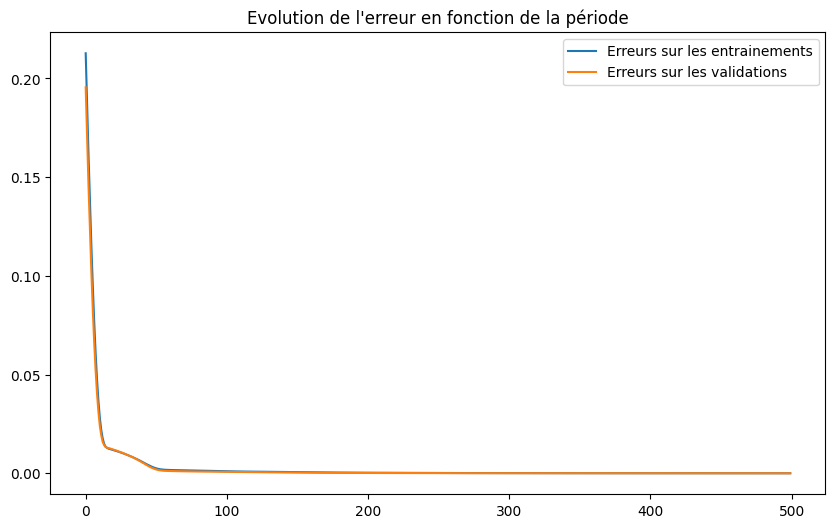

In [24]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

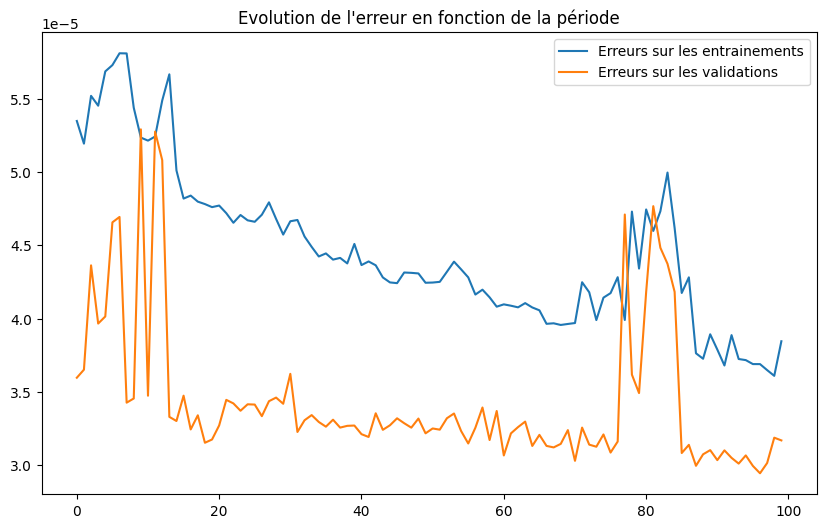

In [25]:
start = 400

erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[start:])),erreur_entrainement[start:], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[start:])),erreur_validation[start:], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

# Chargement du modèle pré-entrainé

**LorenzMap_Wavenet_Univarié**  
  - Single step  
  - profondeur dilation : 3 (longueur_sequence = 16)
  - dim_filtres = 2
  - nbr_filtres = 2
  - régul = 0

	=> mse :  0.00014400063 / 0.00013114203


In [26]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Wavenet/poids_train_LorenzUni.hdf5"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 44728  100 44728    0     0  27150      0  0:00:01  0:00:01 --:--:-- 27150


In [27]:
nbr_filtres = 2
dim_filtres = 2
profondeur_dilation = 3
longueur_sequence = 16
use_bias = False
res_l2 = 0
final_l2 = 0

model =  get_model(longueur_sequence, nbr_filtres, dim_filtres, profondeur_dilation, use_bias, res_l2, final_l2)

In [28]:
model.load_weights("poids_train_LorenzUni.hdf5")

# Prédictions single-step

In [29]:
pred_ent = model.predict(x_train[1],verbose=1)
pred_val = model.predict(x_val[1],verbose=1)

8/8 [==============================] - 0s 10ms/step


In [30]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=serie.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)